## ZEE Recommender System

Problem statement : 

Build a recommender system that's going to recommend movies to a user based on ratings given by a user and other users similar to them in order to improve user experience.

In [1]:
# importing the libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors 
import warnings 
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# reading the data 

movies = pd.read_fwf('zee-movies.dat',encoding='ISO-8859-1')
users = pd.read_fwf('zee-users.dat',encoding='ISO-8859-1')
reviews = pd.read_fwf('zee-ratings.dat',encoding='ISO-8859-1')

In [4]:
movies.head(4)

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN


In [5]:
# drop unnamed columns
movies.drop(['Unnamed: 1','Unnamed: 2'],axis=1,inplace=True)
movies.head(4)

,Movie ID::Title::Genres
0,1::Toy Story (1995)::Animation|Children's|Comedy
1,2::Jumanji (1995)::Adventure|Children's|Fantasy
2,3::Grumpier Old Men (1995)::Comedy|Romance
3,4::Waiting to Exhale (1995)::Comedy|Drama


In [7]:
# split the columns and expand into new columns
movies = movies['Movie ID::Title::Genres'].str.split('::',expand=True)

In [9]:
movies.columns = ['movie_id','title','genres']

In [11]:
movies.head(4)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama


In [13]:
# splitting the reviews 
reviews = reviews['UserID::MovieID::Rating::Timestamp'].str.split('::',expand=True)
reviews.columns = ['user_id','movie_id','rating','timestamp']
reviews.head(4)

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275


In [15]:
# split users and expand into new columns
users = users['UserID::Gender::Age::Occupation::Zip-code'].str.split('::',expand=True)
users.columns = ['user_id','gender','age','occupation','zip_code']
users.head(4)

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460


In [19]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     6040 non-null   object
 1   gender      6040 non-null   object
 2   age         6040 non-null   object
 3   occupation  6040 non-null   object
 4   zip_code    6040 non-null   object
dtypes: object(5)
memory usage: 236.1+ KB


In [17]:
users["age"].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: age, dtype: int64

In [20]:
users.replace({"age" : {"1":"Under 18","18":"18-24",
                        "25":"25-34","35":"25-34",
                        "45":"45-49","50":"50-55","56":"56 Above"}} , inplace = True)



- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"

In [22]:
users.replace({"occupation": {
    "0":"other","1":"academic/educator","2":"artist","3":"clerical/admin",
    "4":"college/grad student","5":"customer service","6":"doctor/health care",
    "7":"executive/managerial","8":"farmer","9":"homemaker","10":"K-12 student",
    "11":"lawyer","12":"programmer","13":"retired","14":"sales/marketing",
    "15":"scientist","16":"self-employed","17":"technician/engineer",
    "18":"tradesman/craftsman","19":"unemployed","20":"writer"}},inplace=True)


## Data pre-processing

In [26]:
print(users.shape , movies.shape , reviews.shape)

(6040, 5) (3883, 3) (1000209, 4)


In [28]:
movies.columns

Index(['movie_id', 'title', 'genres'], dtype='object')

In [29]:
# we can merge movies and reviews
reviews.columns

Index(['user_id', 'movie_id', 'rating', 'timestamp'], dtype='object')

In [30]:
movies.head(3)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [31]:
# extract year from title
movies['year'] = movies['title'].str.extract('.*\((.*)\).*')
movies.head(3)

,movie_id,title,genres,year
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995


In [34]:
# replace year with empty string and then strip it
movies['title'] = movies['title'].str.replace('(\(\d\d\d\d\))', '') 
movies['title'] = movies['title'].apply(lambda x: x.strip())

In [ ]:
# check if genres contain "ro"
movies[movies['genres'].str.contains("Ro",na=False)].sample(15)

In [62]:
# movies['genres'].value_counts()[movies['genres'].value_counts() == 1]

Children's|Sci-Fi                                1
Action|Sci-Fi|Thriller|Western                   1
Adventure|Animation|Children's|Sci               1
Children's|Horror                                1
Action|Crime|Mystery|Thriller                    1
                                                ..
Action|Adventure|Children's                      1
Action|Adventure|Children's|Fantasy              1
Action|Adventure|Sci-Fi|Th                       1
Adventure|Animation|Children's|Comedy|Musical    1
Drama|Fantas                                     1
Name: genres, Length: 188, dtype: int64

There are lot of values in  genres column with incomplete text , let's replace them  with original genre

In [63]:
df_mov = movies.copy() 
df_mov.dropna(inplace=True) 

In [64]:
df_mov['genres'] = df_mov['genres'].str.split('|')

In [68]:
df_mov = df_mov.explode('genres')


In [ ]:
df_mov["genres"].value_counts()

- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western

Manual pre-processing is needed for genre column

In [73]:
# check for romance - ro , romance , roman etc 
df_mov[df_mov["genres"].str.contains("Ro",na=False)]

,movie_id,title,genres,year
2,3,Grumpier Old Men,Romance,1995
6,7,Sabrina,Romance,1995
10,11,"American President, The",Romance,1995
14,15,Cutthroat Island,Romance,1995
16,17,Sense and Sensibility,Romance,1995
...,...,...,...,...
3785,3855,"Affair of Love, An (Une Liaison Pornographique)",Rom,1999
3804,3874,"Couch in New York, A",Romance,1996
3815,3885,Love & Sex,Romance,2000
3818,3888,Skipped Parts,Romance,2000


In [75]:
df_mov[df_mov["genres"].str.contains("Ro",na=False)]["genres"].value_counts().index
#romance
df_mov['genres'] = df_mov['genres'].replace(['Rom', 'Roman', 'Roma', 'Ro','R'], 'romance')

df_mov[df_mov["genres"].str.contains("Ch",na=False)]["genres"].value_counts().index
#  children
df_mov["genres"] = df_mov["genres"].replace(["Children's", 'Childre', 'Children', 'Chil', 'Childr', 'Children''Chi'], "children")
df_mov[df_mov["genres"].str.contains("Fan",na=False)]["genres"].value_counts().index
# replacing with fantasy
df_mov["genres"] = df_mov["genres"].replace(['Fantas', 'Fantas', 'Fantasy','Fant'], 'fantasy')
df_mov[df_mov["genres"].str.contains("Dr",na=False)]["genres"].value_counts().index
#drama
df_mov["genres"] = df_mov["genres"].replace(['Dram', 'Dram', 'Drama', 'Dr'], 'drama')
# documentary
df_mov[df_mov["genres"].str.contains("Doc",na=False)]["genres"].value_counts().index
df_mov["genres"] = df_mov["genres"].replace(['Documenta', 'Document', 'Docu', 'Documen','Documentary'], 'documentary')
df_mov[df_mov["genres"].str.contains("Ad",na=False)]["genres"].value_counts().index
# replacing with adventure
df_mov["genres"] = df_mov["genres"].replace(['Adv', 'Adventu', 'Adventur', 'Advent','Adventure'], 'adventure')

df_mov[df_mov["genres"].str.contains("An",na=False)]["genres"].value_counts().index
# replacing with animation
df_mov["genres"] = df_mov["genres"].replace(['Animati', 'Animation'], 'animation')
df_mov[df_mov["genres"].str.contains("Co",na=False)]["genres"].value_counts().index

df_mov["genres"] = df_mov["genres"].replace(['Come', 'Comed', 'Com','Comedy'], 'comedy')
df_mov[df_mov["genres"].str.contains("Cr",na=False)]["genres"].value_counts().index
# replacing with crime
df_mov["genres"] = df_mov["genres"].replace(['Cr','Crime','Crim','Crime'], 'crime')

# film noir 
df_mov[df_mov["genres"].str.contains("Fi",na=False)]["genres"].value_counts().index

df_mov["genres"] = df_mov["genres"].replace(['Fi','Film-Noir'], 'film-noir')
# horror
df_mov[df_mov["genres"].str.contains("Ho",na=False)]["genres"].value_counts().index

df_mov["genres"] = df_mov["genres"].replace(['Horror', 'Horro', 'Horr'], 'horror')
df_mov[df_mov["genres"].str.contains("Mu",na=False)]["genres"].value_counts().index
#music
df_mov["genres"] = df_mov["genres"].replace(['Musical', 'Music', 'Mus', 'Musical'], 'musical')

df_mov[df_mov["genres"].str.contains("My",na=False)]["genres"].value_counts().index
#mystery
df_mov["genres"] = df_mov["genres"].replace(['My', 'Myst', 'Myster','Mystery'], 'mystery')

df_mov[df_mov["genres"].str.contains("Sci",na=False)]["genres"].value_counts().index
# sci-fi
df_mov["genres"] = df_mov["genres"].replace(['Sci-Fi', 'Sci-', 'Sci', 'Sci-F'], 'sci-fi')

df_mov[df_mov["genres"].str.contains("Th",na=False)]["genres"].value_counts().index 
# thriller
df_mov["genres"] = df_mov["genres"].replace(['Thriller', 'Thri', 'Th', 'Thrille'], 'thriller')

df_mov[df_mov["genres"].str.contains("Wa",na=False)]["genres"].value_counts().index
# war
df_mov["genres"] = df_mov["genres"].replace(['War', 'Wa'], 'war')

df_mov[df_mov["genres"].str.contains("We",na=False)]["genres"].value_counts().index
# western
df_mov["genres"] = df_mov["genres"].replace(['Western', 'Wester', 'We'], 'western')

df_mov[df_mov["genres"].str.contains("Ac",na=False)]["genres"].value_counts().index
# action
df_mov["genres"] = df_mov["genres"].replace(['Action', 'Ac','Acti'], 'action')

df_mov["genres"] = df_mov["genres"].replace(["Children's", 'Childre', 'Children', 'Chil', 'Childr', 'Children','Chi',"Children'"], "children")
df_mov["genres"] = df_mov["genres"].replace(['Romance','romance'],'romance')

# everything else with na   
df_mov["genres"] = df_mov["genres"].replace(['D', 'S', 'A', 'F',''], 'na')

Index(['Romance', 'Rom', 'Roman', 'Roma', 'Ro'], dtype='object')

<AxesSubplot: >

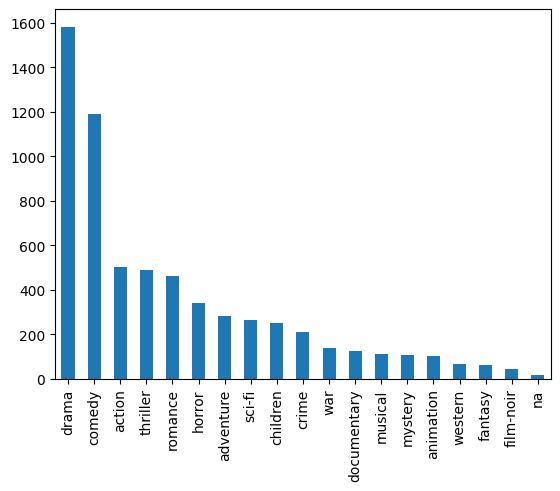

In [137]:
df_mov["genres"].value_counts().plot(kind='bar')

In [138]:
df_mov.head(4)

,movie_id,title,genres,year
0,1,Toy Story,animation,1995
0,1,Toy Story,children,1995
0,1,Toy Story,comedy,1995
1,2,Jumanji,adventure,1995


In [140]:
reviews.head(4)

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275


In [145]:
df_1 = pd.merge(df_mov, reviews, on='movie_id') 
df_1.head(4)

,movie_id,title,genres,year,user_id,rating,timestamp
0,1,Toy Story,animation,1995,1,5,978824268
1,1,Toy Story,animation,1995,6,4,978237008
2,1,Toy Story,animation,1995,8,4,978233496
3,1,Toy Story,animation,1995,9,5,978225952


In [148]:
df_1.shape

(2060031, 7)

In [147]:
users.head(4)

,user_id,gender,age,occupation,zip_code
0,1,F,Under 18,K-12 student,48067
1,2,M,56 Above,self-employed,70072
2,3,M,25-34,scientist,55117
3,4,M,45-49,executive/managerial,02460


In [149]:
mix_df = pd.merge(df_1, users, on='user_id',how='inner')

In [150]:
mix_df.head(4)

,movie_id,title,genres,year,user_id,rating,timestamp,gender,age,occupation,zip_code
0,1,Toy Story,animation,1995,1,5,978824268,F,Under 18,K-12 student,48067
1,1,Toy Story,children,1995,1,5,978824268,F,Under 18,K-12 student,48067
2,1,Toy Story,comedy,1995,1,5,978824268,F,Under 18,K-12 student,48067
3,48,Pocahontas,animation,1995,1,5,978824351,F,Under 18,K-12 student,48067


In [153]:
mix_df.isna().sum()

movie_id      0
title         0
genres        0
year          0
user_id       0
rating        0
timestamp     0
gender        0
age           0
occupation    0
zip_code      0
dtype: int64

In [154]:
mix_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2060031 entries, 0 to 2060030
Data columns (total 11 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   movie_id    object
 1   title       object
 2   genres      object
 3   year        object
 4   user_id     object
 5   rating      object
 6   timestamp   object
 7   gender      object
 8   age         object
 9   occupation  object
 10  zip_code    object
dtypes: object(11)
memory usage: 188.6+ MB


In [155]:
mix_df["rating"] = mix_df["rating"].astype('int32')

mix_df["datetime"] = pd.to_datetime(mix_df['timestamp'], unit='s')

In [160]:
mix_df["year"] = mix_df["year"].astype('int32')

<AxesSubplot: >

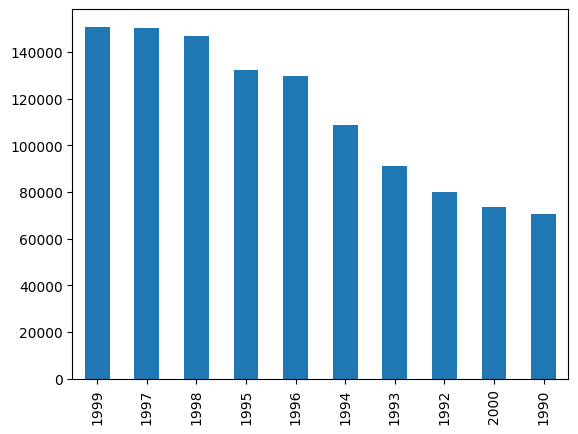

In [164]:
mix_df["year"].value_counts().nlargest(10).plot(kind='bar')

In [169]:
print(mix_df["year"].min(), mix_df["year"].max())

1919 2000


Data contanis movies released from 1919 to 2000

In [181]:
# let's bin the data for every ten years 
bins = [1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 2000] 
labels = ['20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s'] 
mix_df["release_bins"] = pd.cut(mix_df["year"], bins=bins, labels=labels,include_lowest=True)

In [185]:
mix_df.head(3)

,movie_id,title,genres,year,user_id,rating,timestamp,gender,age,occupation,zip_code,datetime,release_bins
0,1,Toy Story,animation,1995,1,5,978824268,F,Under 18,K-12 student,48067,2001-01-06 23:37:48,90s
1,1,Toy Story,children,1995,1,5,978824268,F,Under 18,K-12 student,48067,2001-01-06 23:37:48,90s
2,1,Toy Story,comedy,1995,1,5,978824268,F,Under 18,K-12 student,48067,2001-01-06 23:37:48,90s


In [183]:
mix_df[mix_df["year"] == 1919].shape

(48, 13)

In [184]:
mix_df.isna().sum()

movie_id        0
title           0
genres          0
year            0
user_id         0
rating          0
timestamp       0
gender          0
age             0
occupation      0
zip_code        0
datetime        0
release_bins    0
dtype: int64